In [1]:
import sys
print(sys.executable)


c:\Users\khize\AppData\Local\Programs\Python\Python310\python.exe


In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.utils import plot_model

## Prepare the data

In [2]:
# Dataset Parameters
root = './dataset/'
batch_size = 44
img_height = 256
img_width = 256
seed = np.random.randint(0, 128)

In [3]:
# importing the training split
train_ds = keras.utils.image_dataset_from_directory(
  root + 'train/',
  validation_split=None,
  seed=seed,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NotFoundError: Could not find directory ./dataset/train/

In [4]:
# importing the validation split
val_ds = keras.utils.image_dataset_from_directory(
  root + 'test/',
  validation_split=None,
  seed=seed,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size//3)

NotFoundError: Could not find directory ./dataset/test/

# Hyperparameter initialisation and Dataset finalization

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [6]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

NameError: name 'train_ds' is not defined

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

NameError: name 'train_ds' is not defined

In [8]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = np.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

NameError: name 'train_ds' is not defined

In [9]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, val=True):
        super().__init__()
        self.val = val
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(21,7))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if self.val:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_'+metric], 
                            label='validation '+metric)
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [11]:
# Define an EarlyStopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.0075,         # Minimum change in accuracy to be considered an improvement
    patience=10,               # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore model weights to the best checkpoint
)

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(8, 8, (1, 1), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(16, 7, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  # layers.MaxPooling2D((3, 3)),
  layers.Conv2D(24, 6, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(32, 5, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(40, 4, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(48, 3, (1, 1), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  # layers.Conv2D(12, 3, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  # layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dropout(0.35),
  # layers.Dense(32 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  # layers.Dropout(0.35),
  layers.Dense(16 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dropout(0.3),
  layers.Dense(8 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.00025),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[
    'accuracy', 
    keras.metrics.Recall(thresholds=0.5, class_id=None, name='recall')
])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[
    tensorboard_callback, 
    PlotLearning(val=True),
    early_stopping_callback
    ]
)

NameError: name 'class_names' is not defined

In [14]:
model.evaluate(val_ds)

NameError: name 'model' is not defined

In [15]:
images = []
labels = []

for x, y in train_ds.unbatch().take(250):
    images.append(x)
    labels.append(np.argmax(y).item())

NameError: name 'train_ds' is not defined

In [16]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras')

NameError: name 'model' is not defined

In [17]:
test = np.array(images)

In [18]:
y_pred = (model.predict(test)).argmax(axis=1)

NameError: name 'model' is not defined

In [ ]:
y_pred

array([12, 15,  3,  3, 18, 22, 17,  3, 11,  8, 11,  8,  8, 18, 17, 13,  0,
       10, 22,  3, 22, 11, 22,  6,  9,  0, 10,  3,  5,  5,  0,  8, 15, 17,
       17, 15,  8,  5, 15, 12,  5,  1, 13, 12, 10,  3, 18, 10,  3,  1, 21,
       22, 17,  7,  9,  4, 17,  4, 12,  8,  5,  7, 22,  0, 11,  4,  1, 22,
        3, 20,  8,  1, 15,  5,  8, 20, 14, 22, 14,  1,  7,  0, 14, 17, 14,
       21,  7, 15, 22, 11,  8, 10,  0, 17,  0, 21, 18, 18,  2, 17, 11,  1,
       14,  6,  9, 15,  8, 22,  6, 22,  1,  9,  5,  1, 17, 22, 22, 17, 10,
        7, 20, 22, 17, 22, 11, 22,  8,  5, 19, 15, 10, 11,  1,  8,  1,  2,
       12,  1, 14,  9, 21, 21, 22, 22, 10,  6, 13,  6, 19,  6, 12,  0, 17,
        5, 11,  1, 16, 21, 13, 10,  1, 22,  3, 10,  3, 17, 22,  7, 10,  5,
        5, 10, 22, 15,  7, 17,  8,  5,  2, 17, 10,  0,  1,  6, 14, 14,  6,
        5,  1, 17, 18, 10, 13,  1, 17,  8, 15,  8,  8,  1,  1, 22, 10,  5,
       10,  8, 21,  8, 17,  0, 21, 16, 17,  1, 10, 18,  1, 11,  6,  5,  8,
        3, 22,  6, 15, 15

In [ ]:
print(labels)

[12, 15, 3, 16, 18, 22, 17, 15, 11, 8, 11, 8, 8, 18, 17, 13, 0, 10, 22, 3, 18, 11, 7, 6, 9, 0, 10, 16, 5, 5, 0, 8, 15, 17, 17, 15, 8, 5, 15, 12, 17, 1, 13, 10, 10, 3, 18, 10, 3, 1, 21, 13, 17, 7, 9, 4, 4, 4, 12, 8, 5, 7, 22, 0, 11, 4, 1, 22, 3, 20, 8, 1, 15, 5, 8, 20, 14, 22, 14, 1, 7, 0, 14, 17, 14, 21, 7, 15, 22, 11, 3, 10, 0, 17, 0, 7, 15, 18, 2, 17, 11, 1, 14, 6, 9, 15, 8, 22, 6, 22, 1, 9, 5, 1, 17, 22, 22, 17, 17, 7, 20, 22, 17, 17, 11, 22, 8, 5, 19, 15, 10, 11, 1, 18, 1, 2, 12, 1, 14, 9, 21, 21, 16, 22, 10, 6, 13, 6, 19, 18, 22, 0, 17, 5, 11, 1, 16, 21, 13, 10, 1, 22, 3, 10, 1, 3, 22, 7, 10, 5, 14, 10, 17, 15, 7, 17, 6, 5, 2, 17, 10, 0, 1, 6, 20, 14, 6, 5, 1, 17, 18, 10, 13, 1, 1, 8, 15, 8, 8, 1, 1, 3, 10, 5, 10, 8, 21, 8, 17, 0, 21, 16, 17, 1, 10, 18, 1, 11, 21, 5, 16, 3, 22, 6, 15, 15, 11, 19, 9, 10, 9, 11, 3, 9, 22, 15, 22, 5, 9, 3, 0, 8, 3, 15, 15, 10, 3, 12, 12, 21]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                               precision    recall  f1-score   support

                             Acne, or Rosacea       1.00      1.00      1.00        11
Actinic Keratosis, or other Malignant Lesions       1.00      0.91      0.95        22
             Alopecia, or other Hair Diseases       1.00      1.00      1.00         3
                            Atopic Dermatitis       0.71      0.71      0.71        14
                         Bacterial Infections       1.00      0.75      0.86         4
                                Benign Tumors       0.88      1.00      0.93        14
                              Bullous Disease       0.80      0.89      0.84         9
                   Connective Tissue Diseases       1.00      0.78      0.88         9
                                       Eczema       0.80      1.00      0.89        16
                 Exanthems, or Drug Eruptions       1.00      1.00 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 249, 249, 8)       1544      
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 16)      6288      
                                                                 
 conv2d_14 (Conv2D)          (None, 59, 59, 24)        13848     
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        19232     
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 40)        20520     
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 48)       

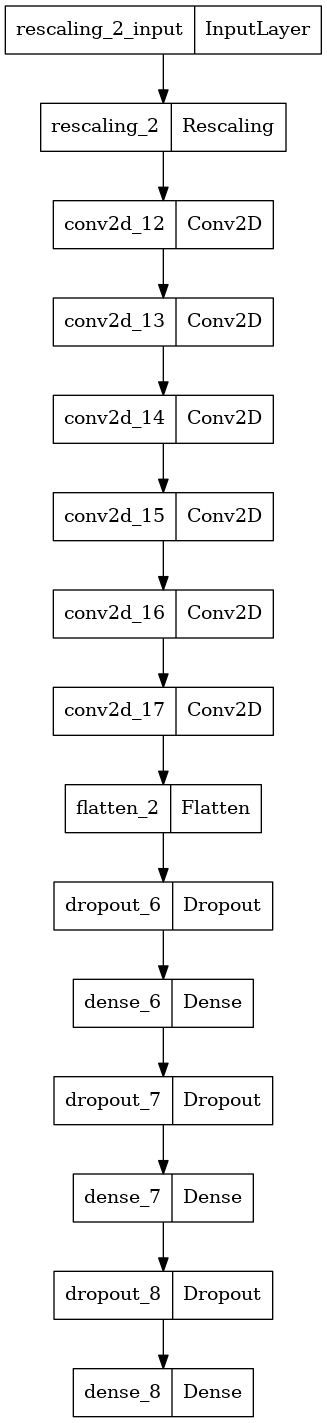

In [ ]:
plot_model(model)

In [ ]:
lmao = model.history

<Figure size 640x480 with 0 Axes>

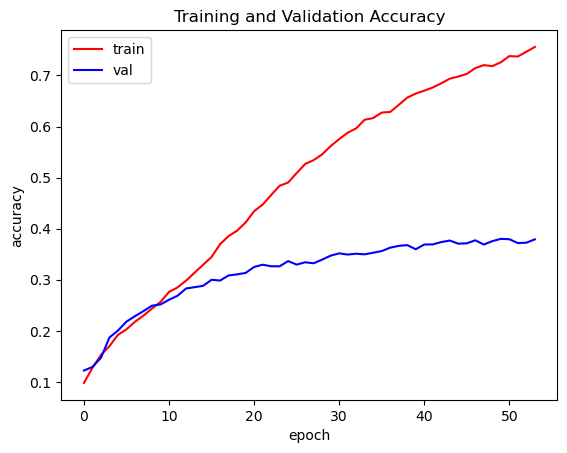

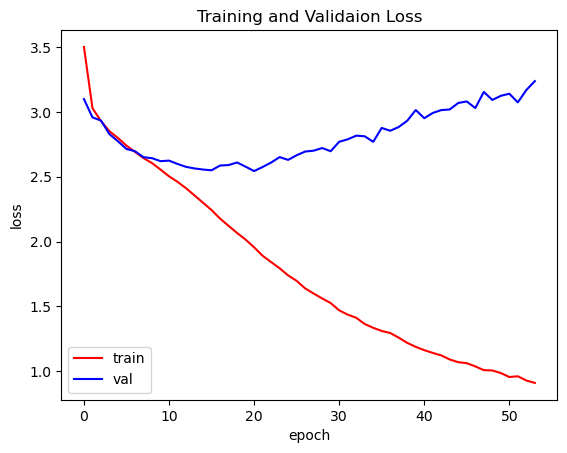

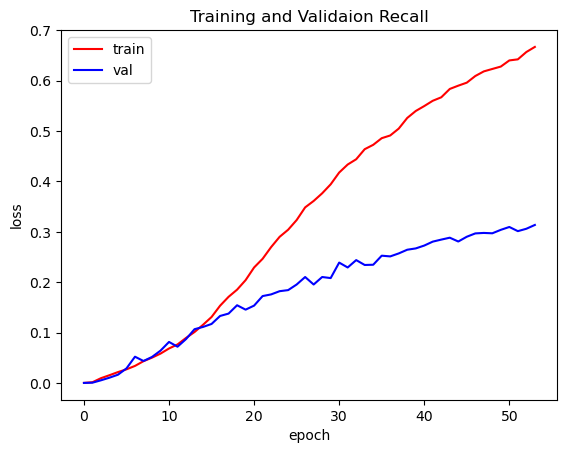

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']
rec = fit.history['recall']
val_rec = fit.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.title('Training and Validaion Loss')
plt.figure()

plt.plot(epochs, rec, 'r')
plt.plot(epochs, val_rec, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.title('Training and Validaion Recall')
plt.figure()

In [ ]:
model.save('./models/BEST-cnn.keras')

In [1]:
# test loading model
test = keras.models.load_model('./models/BEST-cnn.keras')

NameError: name 'keras' is not defined